__Note:__
- Following notebook uses the oxford pets dataset which can be downloaded from https://www.robots.ox.ac.uk/~vgg/data/pets/
- This notebook includes some optimization techniques which can speed up your training process
- It uses torchvision pretrained model VGG for transfer learning (There are multiple libraries which can be used for getting models for transfer learning for classification. This include torchvision, torch hub, timm, etc.) (Part 02)

REFERENCES: 

1. https://chtalhaanwar.medium.com/pytorch-num-workers-a-tip-for-speedy-training-ed127d825db7
2. https://towardsdatascience.com/optimize-pytorch-performance-for-speed-and-memory-efficiency-2022-84f453916ea6
3. https://discuss.pytorch.org/t/what-is-the-disadvantage-of-using-pin-memory/1702

# Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import kornia as K
from torch import optim
from torchsummary import summary
from torchvision import models
import random
from tqdm import tqdm
import time

# For file and directory related operation
import os
import pathlib
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Setting Seed for reproducibility
seed = 42
random.seed(seed)
torch.manual_seed(seed)  
torch.cuda.manual_seed(seed)  
torch.cuda.manual_seed_all(seed)  
torch.backends.cudnn.deterministic = True

__TRANSFER LEARNING:__ 

Transfer learning is an approach to use the model trained on another task (possibly large dataset) and use it for another task (possibly related task for eg. Training on large scale natural images and using it later for medical imaging dataset might not work too well but it can be used). 

For CNN this is due to the fact that the earlier layers learns the filters which can be seen as edge detection filters and thus if trained on large dataset, it might efficiently detect edges to a greater extent which may be further be used for some other task.

# Hyperparameters

In [2]:
# mean and std-dev taken from imagenet dataset
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
in_channels = 3
batch_size = 32
valid_size = 0.2
resize_side = 360
output_image_crop = (224, 224)
dropout_p = 0.0
img_aug_p = 0.5
learning_rate = 1e-04

# Loading Data

In [3]:
base_path = pathlib.Path('./data/pets_dataset/images')
all_images = list(base_path.glob('./*.jpg'))
all_images[:10]

[PosixPath('data/pets_dataset/images/american_bulldog_143.jpg'),
 PosixPath('data/pets_dataset/images/yorkshire_terrier_176.jpg'),
 PosixPath('data/pets_dataset/images/pomeranian_98.jpg'),
 PosixPath('data/pets_dataset/images/yorkshire_terrier_1.jpg'),
 PosixPath('data/pets_dataset/images/Siamese_168.jpg'),
 PosixPath('data/pets_dataset/images/english_setter_86.jpg'),
 PosixPath('data/pets_dataset/images/keeshond_36.jpg'),
 PosixPath('data/pets_dataset/images/staffordshire_bull_terrier_19.jpg'),
 PosixPath('data/pets_dataset/images/Ragdoll_130.jpg'),
 PosixPath('data/pets_dataset/images/chihuahua_195.jpg')]

It is evident and also mentioned on the website of the dataset that the label of the image is in the file.

In [4]:
def get_label(fname):
    # Get filename without extension
    class_name = fname.stem
    # Remove the number from the file name
    class_ = class_name[:class_name.rfind('_')]
    return class_
print(all_images[0])
get_label(all_images[0])

data/pets_dataset/images/american_bulldog_143.jpg


'american_bulldog'

In [5]:
def clean_data(all_images):
    # Cleaning Data
    count = 0
    for img_path in tqdm(all_images):
        # Reading Error
        try:
            img = plt.imread(img_path)
        except:
            os.remove(img_path)
            count += 1
            continue
        # Grayscale image or has an alpha channel
        if len(img.shape) != 3 or img.shape[2] != 3:
            os.remove(img_path)
            count+=1
    print(f"Removed {count} images")
# clean_data(all_images)

In [6]:
unique_labels = list(set([get_label(fname) for fname in all_images]))
label_to_idx = {category:idx for idx, category in enumerate(unique_labels)}
print(f"Dataset Consists of {len(all_images)} images and {len(unique_labels)} categories")
print(unique_labels)

Dataset Consists of 7378 images and 37 categories
['great_pyrenees', 'chihuahua', 'Birman', 'leonberger', 'Egyptian_Mau', 'wheaten_terrier', 'american_bulldog', 'boxer', 'pug', 'Bengal', 'beagle', 'english_setter', 'shiba_inu', 'Persian', 'english_cocker_spaniel', 'Abyssinian', 'havanese', 'keeshond', 'staffordshire_bull_terrier', 'Bombay', 'miniature_pinscher', 'japanese_chin', 'Siamese', 'american_pit_bull_terrier', 'german_shorthaired', 'Maine_Coon', 'newfoundland', 'saint_bernard', 'samoyed', 'yorkshire_terrier', 'pomeranian', 'scottish_terrier', 'Russian_Blue', 'Sphynx', 'Ragdoll', 'British_Shorthair', 'basset_hound']


In [7]:
# Augmentation
class Augmentation(nn.Module):
    def __init__(self, resize_img, output_crop, mean, 
                 std, aug_p = 0.5, train = True):
        
        super(Augmentation, self).__init__()
        self.train = train
        self.resize = K.augmentation.Resize(resize_img, side = 'long')
        self.padding = K.augmentation.PadTo((resize_img, resize_img))
        if train:
            deg_rot = 30
            translate = (0.1, 0.1)
            scale = (0.8,1.1)
            # same_on_batch = True to apply same transformation on batch
            self.affine_aug = K.augmentation.RandomAffine(deg_rot, translate, scale = scale, p = aug_p)
            self.horizontal_flip = K.augmentation.RandomHorizontalFlip(p = aug_p)
            
        self.cropping = K.augmentation.RandomCrop(output_crop, p =1.0)
        self.normalization = K.augmentation.Normalize(mean = mean, std = std)
    
    def forward(self, img):
        if self.train:
            img_aug = self.affine_aug(self.horizontal_flip(self.resize(img)))
        img_aug = self.normalization(self.cropping(img_aug))
        return img_aug

In [8]:
class PetsDataset(Dataset):
    def __init__(self, images_path, all_categories, label_to_idx, augment):
        self.images_path = images_path
        self.all_categories = all_categories
        self.label_to_idx = label_to_idx
        self.augment = augment
        
    def __len__(self):
        return len(self.images_path)
    
    def __getitem__(self, idx):
        img_name = self.images_path[idx]
        lbl = self.get_label(img_name)
        lbl = torch.tensor(lbl)
        img = plt.imread(img_name) / 255.
        img = torch.tensor(np.transpose(img, (2, 0, 1)))
        final_img = self.augment.padding(self.augment.resize(img))[0]
        return final_img, lbl
    
    def get_label(self, fname):
        class_name = fname.stem
        label = self.label_to_idx[class_name[:class_name.rfind('_')]]
        return label
    
    def batch_augmentation(self, batch):
        imgs, lbls = list(zip(*batch))
        imgs = torch.stack(imgs)
        lbls = torch.tensor(lbls)
        imgs = self.augment(imgs)
        return imgs, lbls

In [9]:
train_augmentation = Augmentation(resize_side, output_image_crop, mean, std, img_aug_p, train = True)
train_dataset = PetsDataset(all_images, unique_labels, label_to_idx, train_augmentation)
trainloader = DataLoader(train_dataset, batch_size = batch_size, 
                         collate_fn=train_dataset.batch_augmentation, shuffle = True)

In [10]:
imgs, lbls = next(iter(trainloader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


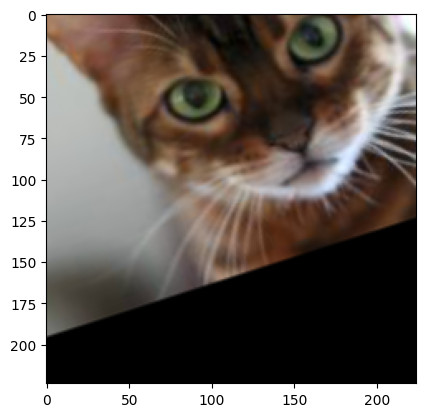

In [11]:
denorm = K.augmentation.Denormalize(mean =mean, std = std)
denorm_img = denorm(imgs[5])[0]
plt.imshow(np.transpose(denorm_img.cpu().detach().numpy(), (1,2,0)))

# Increasing num_worker

In [12]:
# For checking number of num_loaders in the Dataloader (Depends on the machine)
import multiprocessing as mp
for num_worker in range(1, mp.cpu_count(), 2):
    trainloader = DataLoader(train_dataset, batch_size = batch_size, num_workers = num_worker,
                             collate_fn=train_dataset.batch_augmentation, shuffle = True)
    start = time.time()
    for epoch in range(3):
        for idx, data in tqdm(enumerate(trainloader), total = 50, leave = False):
            # Checking for 50 batch
            if idx == 50:
                break
            pass
    end = time.time()
    print(f"Num Workers: {num_worker} took {end - start}s")

Num Workers: 1 took 134.37699627876282s


Num Workers: 3 took 53.05451703071594s


Num Workers: 5 took 38.311365604400635s


Num Workers: 7 took 32.639572620391846s


Num Workers: 9 took 29.783518314361572s


Num Workers: 11 took 29.545797109603882s


Num Workers: 13 took 29.580023527145386s


Num Workers: 15 took 33.76863431930542s


Num Workers: 17 took 36.68097424507141s


Num Workers: 19 took 37.76634168624878s


Num Workers: 21 took 40.67931365966797s


Num Workers: 23 took 42.624908208847046s


Num Workers: 25 took 41.37652111053467s


Num Workers: 27 took 39.29154634475708s


Num Workers: 29 took 41.892945528030396s


Num Workers: 31 took 44.73316550254822s


For me around 11 workers (I will take as 8 [ nearest power of 2 ]) works well. It loads 50 batches in 3 epochs in the minimum time

# Disabling Pin Memory

In [13]:
train_augmentation = Augmentation(resize_side, output_image_crop, mean, std, img_aug_p, train = True)
train_dataset = PetsDataset(all_images, unique_labels, label_to_idx, train_augmentation)
trainloader = DataLoader(train_dataset, batch_size = batch_size, num_workers = 8,
                         collate_fn=train_dataset.batch_augmentation, shuffle = True)

start = time.time()
for epoch in range(5):
    progress_bar = tqdm(trainloader, total = len(trainloader), leave = False)
    for data in progress_bar:
        imgs, lbls = data[0].to(device), data[1].to(device)
        pass
    
end = time.time()
print(f"Total time taken without pin_memory: {end - start}s")


Total time taken without pin_memory: 198.0494396686554s


# Enabling pin memory

In [14]:
train_augmentation = Augmentation(resize_side, output_image_crop, mean, std, img_aug_p, train = True)
train_dataset = PetsDataset(all_images, unique_labels, label_to_idx, train_augmentation)
trainloader = DataLoader(train_dataset, batch_size = batch_size, num_workers = 8, pin_memory = True,
                         collate_fn=train_dataset.batch_augmentation, shuffle = True)

start = time.time()
for epoch in range(5):
    progress_bar = tqdm(trainloader, total = len(trainloader), leave = False)
    for data in progress_bar:
        imgs, lbls = data[0].to(device, non_blocking=True), data[1].to(device, non_blocking=True)
        pass
    
end = time.time()
print(f"Total time taken without pin_memory: {end - start}s")


Total time taken without pin_memory: 193.67639064788818s


With pin memory, it performs slightly better